#LINK TO GOOGLE DRIVE

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


#SET UP

import libraries

In [ ]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

fix seed and parameters

In [ ]:
seed = 54
np.random.seed(seed)
tf.random.set_seed(seed)

BATCH_SIZE = 32
LEARNING_RATE = 1e-3
PATIENCE = 40
EPOCHS = 150
NUM_OUTPUTS = 4

load and split the data

In [ ]:
data_no_aliens = np.load("No_aliens_float64.npz")
X_train_val, y_train_val = data_no_aliens['arr_0'], data_no_aliens['arr_1']
X_test = np.load("mars_for_students.npz")["test_set"]
X_training, X_val, y_training, y_val = train_test_split(X_train_val, y_train_val, random_state = seed, test_size = 0.1)
training_set = tf.data.Dataset.from_tensor_slices((X_training,{'o' + str(i+1): y_training for i in range(NUM_OUTPUTS)}))
training_set = training_set.batch(BATCH_SIZE, drop_remainder = False).prefetch(tf.data.AUTOTUNE)

#MODEL AND TRAINING

build the model

In [ ]:
def unet_block(input_tensor, filters, kernel_size = 3, stack = 2, name = ''):
    x = input_tensor
    for i in range(stack):
        x = tfkl.BatchNormalization(name = name + '_bn' + str(i + 1))(x)
        x = tfkl.Conv2D(filters, kernel_size = kernel_size, padding = 'same', name = name + '_conv' + str(i + 1))(x)
        x = tfkl.LeakyReLU(0.15, name = name + '_lr' + str(i + 1))(x)
        x = tfkl.Dropout(0.3, name = name + '_do' + str(i + 1))(x)
    return x

def get_model(input_shape = (64, 128, 1), num_classes = 5, seed = seed, num_outputs = NUM_OUTPUTS):
    tf.random.set_seed(seed)
    il = tfkl.Input(shape = input_shape, name = 'input_layer')

    d = [unet_block(il,  32, name = 'd0')]          #down path
    b = []                                          #bottlenecks
    o = []                                          #outputs
    for j in range(num_outputs):
        d.append(unet_block(tfkl.MaxPooling2D()(d[j]),  2**(6+j), 3 + (num_outputs - 1 - j)*1, name = 'd' + str(j + 1)))
        b.append(unet_block(tfkl.MaxPooling2D()(d[j+1]), 2**(7+j), name = 'b' + str(j + 1)))
        u = unet_block(tfkl.UpSampling2D()(b[j]), 2**(6+j), name = 'u' + str(j + 1))
        for k in range(j+1):
            u = unet_block(tfkl.Concatenate()([tfkl.UpSampling2D()(u),d[j-k]]), 2**(6+j-k-1), name = 'u' + str(j + 1) + '_' + str(k))
        o.append(tfkl.Conv2D(num_classes, kernel_size = 1, padding = 'same', activation = "softmax", name = 'o' + str(j + 1))(u))

    model = tf.keras.Model(inputs = il, outputs = o, name = 'general' + str(num_outputs))
    return model

compile the model and define callbacks

In [ ]:
model = get_model()
model.summary()

model.compile(
    loss = {'o' + str(i+1): tfk.losses.SparseCategoricalCrossentropy(ignore_class = 0, name = 'l' + str(i+1)) for i in range(NUM_OUTPUTS)},
    optimizer = tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics={'o' + str(i+1): tfk.metrics.MeanIoU(num_classes=5, ignore_class=0, sparse_y_pred=False, name='m'+str(i+1)) for i in range(NUM_OUTPUTS)}
)
early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_o' + str(NUM_OUTPUTS) + '_m' + str(NUM_OUTPUTS),
    mode = 'max',
    patience = PATIENCE,
    restore_best_weights = True
)

Model: "general4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d0_bn1                    │ (None, 64, 128, 1)     │              4 │ input_layer[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d0_conv1 (Conv2D)         │ (None, 64, 128, 32)    │            320 │ d0_bn1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d0_lr1 (LeakyReLU)        │ (None, 64, 128, 32)    │              0 │ d0_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d0_do1 (Dropout)          │ (None, 64, 128, 32)    │              0 │ d0_lr1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d0_bn2                    │ (None, 64, 128, 32)    │            128 │ d0_do1[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d0_conv2 (Conv2D)         │ (None, 64, 128, 32)    │          9,248 │ d0_bn2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d0_lr2 (LeakyReLU)        │ (None, 64, 128, 32)    │              0 │ d0_conv2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d0_do2 (Dropout)          │ (None, 64, 128, 32)    │              0 │ d0_lr2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 32)     │              0 │ d0_do2[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d1_bn1                    │ (None, 32, 64, 32)     │            128 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d1_conv1 (Conv2D)         │ (None, 32, 64, 64)     │         73,792 │ d1_bn1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d1_lr1 (LeakyReLU)        │ (None, 32, 64, 64)     │              0 │ d1_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d1_do1 (Dropout)          │ (None, 32, 64, 64)     │              0 │ d1_lr1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d1_bn2                    │ (None, 32, 64, 64)     │            256 │ d1_do1[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d1_conv2 (Conv2D)         │ (None, 32, 64, 64)     │        147,520 │ d1_bn2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ d1_lr2 (LeakyReLU)        │ (None, 32, 64, 64)     │              0 │ d1_conv2[0][0]         │
├──────────────────────

 Total params: 38,338,936 (146.25 MB)

 Trainable params: 38,317,814 (146.17 MB)

 Non-trainable params: 21,122 (82.51 KB)

train with early stopping and save the model

In [ ]:
history = model.fit(
    training_set,
    epochs = EPOCHS,
    validation_data=[X_val, {'o' + str(i+1): y_val for i in range(NUM_OUTPUTS)}],
    callbacks = [early_stopping],
    verbose = 1
).history
final_val_meanIoU = round(max(history['val_o' + str(NUM_OUTPUTS) + '_m' + str(NUM_OUTPUTS)])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)
del model
print(f"Model saved to {model_filename}")

Epoch 1/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - loss: 6.0327 - o1_loss: 1.5233 - o1_m1: 0.1569 - o2_loss: 1.4195 - o2_m2: 0.1623 - o3_loss: 1.5250 - o3_m3: 0.1608 - o4_loss: 1.5646 - o4_m4: 0.1451 - val_loss: 42.3914 - val_o1_loss: 8.8234 - val_o1_m1: 0.0670 - val_o2_loss: 11.2019 - val_o2_m2: 0.0671 - val_o3_loss: 10.5307 - val_o3_m3: 0.0674 - val_o4_loss: 11.7588 - val_o4_m4: 0.0668
Epoch 2/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 363ms/step - loss: 3.7943 - o1_loss: 0.9522 - o1_m1: 0.2316 - o2_loss: 0.9233 - o2_m2: 0.2464 - o3_loss: 0.9434 - o3_m3: 0.2461 - o4_loss: 0.9753 - o4_m4: 0.2332 - val_loss: 32.4783 - val_o1_loss: 4.6916 - val_o1_m1: 0.0669 - val_o2_loss: 7.7506 - val_o2_m2: 0.0669 - val_o3_loss: 9.1006 - val_o3_m3: 0.0668 - val_o4_loss: 10.8677 - val_o4_m4: 0.0678
Epoch 3/150
71/71 ━━━━━━━━━━━━━━━━━━━━ 39s 340ms/step - loss: 3.2532 - o1_loss: 0.8313 - o1_m1: 0.2927 - o2_loss: 0.7893 - o2_m2: 0.3206 - o3_loss: 0.8153 - o3_m3: 0.3154 - o4_loss: 0.8172 - o4_m4: 0.3108 - val_l

plot results

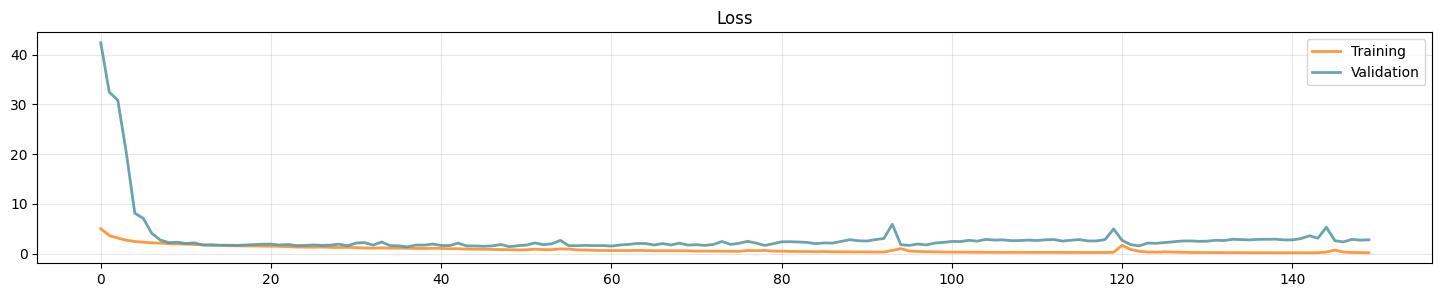

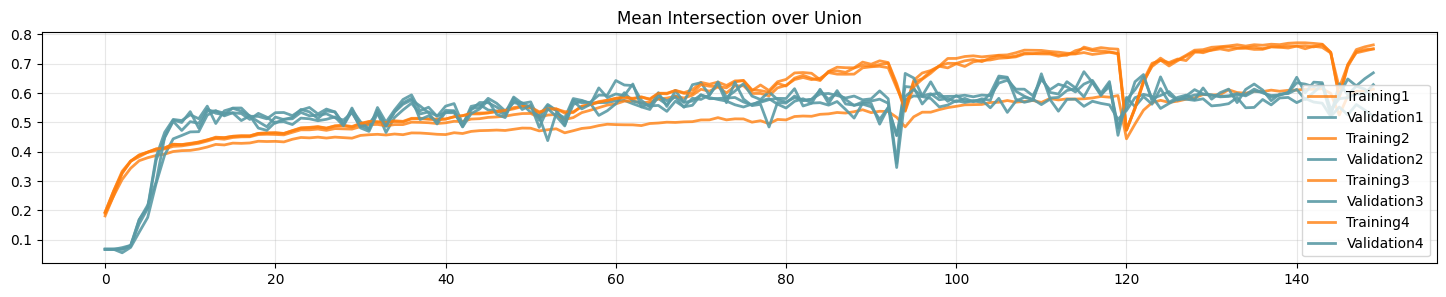

In [ ]:
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label = 'Training', alpha = 0.8, color = '#ff7f0e', linewidth = 2)
plt.plot(history['val_loss'], label = 'Validation', alpha = 0.9, color = '#5a9aa5', linewidth = 2)
plt.title('Loss')
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

plt.figure(figsize=(18, 3))
for i in range(NUM_OUTPUTS):
    plt.plot(history['o'+ str(i+1) + '_m' + str(i+1)], label = 'Training' + str(i+1), alpha = 0.8, color = '#ff7f0e', linewidth = 2)
    plt.plot(history['val_o'+ str(i+1) + '_m' + str(i+1)], label = 'Validation'+ str(i+1), alpha = 0.9, color = '#5a9aa5', linewidth = 2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

#PREDICT

make predictions

In [ ]:
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

# Only the last output is used to predict
preds = model.predict(X_test)[NUM_OUTPUTS-1]
preds = np.argmax(preds, axis=-1)

#four outputs are too much for Colab to handle. Anyway, three were observed not to increase the performance of the model

Model loaded from UNet_67.3.keras
314/314 ━━━━━━━━━━━━━━━━━━━━ 40s 100ms/step


ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_314_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[10022,64,128,5] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

convert to csv

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)